## Functions to build and plot ccd image

In [1]:
import pyfits
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.ndimage as ndimage


def fill_seg_dict(d):
    seg_dict = {}
    for i in np.arange(1,17):
        datasec = [d[i].header['DATASEC'].strip('[]').split(',')[0].split(':')[0],
                  d[i].header['DATASEC'].strip('[]').split(',')[0].split(':')[1],
                  d[i].header['DATASEC'].strip('[]').split(',')[1].split(':')[0],
                  d[i].header['DATASEC'].strip('[]').split(',')[1].split(':')[1]]
        detsec = [d[i].header['DETSEC'].strip('[]').split(',')[0].split(':')[0],
                  d[i].header['DETSEC'].strip('[]').split(',')[0].split(':')[1],
                  d[i].header['DETSEC'].strip('[]').split(',')[1].split(':')[0],
                  d[i].header['DETSEC'].strip('[]').split(',')[1].split(':')[1]]
        detsize = [d[i].header['DETSIZE'].strip('[]').split(',')[0].split(':')[0],                      
                   d[i].header['DETSIZE'].strip('[]').split(',')[0].split(':')[1],
                  d[i].header['DETSIZE'].strip('[]').split(',')[1].split(':')[0],
                  d[i].header['DETSIZE'].strip('[]').split(',')[1].split(':')[1]]
     
        seg_dict[d[i].header['EXTNAME']] = {'datasec':list(map(int,datasec)),
                                           'detsec':list(map(int,detsec)),
                                           'detsize':list(map(int,detsize)),
                                           'data':d[i].data-d[i].header['AVGBIAS']}
    return seg_dict


def channel_intercal(seg_dict, ref_channel_mean):

    norm=np.zeros(16)
    for i,seg in enumerate(list(seg_dict.keys())):
        xmin = seg_dict[seg]['datasec'][0]
        xmax = seg_dict[seg]['datasec'][1]
        ymin = seg_dict[seg]['datasec'][2]
        ymax = seg_dict[seg]['datasec'][3]
        
        filt=np.abs(seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1].flatten()\
                    - np.median(seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1]))\
        <2*np.std(seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1])

        norm = ref_channel_mean / np.median(seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1].flatten()[filt])    
        seg_dict[seg]['intercalib']=norm

def channel_gain_from_Fe55(ccd_names, datafile):
    gains = np.genfromtxt(datafile, usecols=(3), dtype=None)
    d_gains = {ccd: gains[16*i:16*i+16] for i,ccd in enumerate(ccd_names)}
    return d_gains
    
def channel_intercal_with_Fe55_gains(seg_dict, gains):
    for i,seg in enumerate(sorted(list(seg_dict.keys()))):
        seg_dict[seg]['Fe55_gains'] = gains[i]
    
def make_ccd_image(seg_dict, seg_dict_cal, intercal=False):
    img_tot = np.empty(shape=(seg_dict['Segment00']['detsize'][3],seg_dict['Segment00']['detsize'][1]))
    for seg in seg_dict.keys():
        xmin = seg_dict[seg]['datasec'][0]
        xmax = seg_dict[seg]['datasec'][1]
        ymin = seg_dict[seg]['datasec'][2]
        ymax = seg_dict[seg]['datasec'][3]
        xmin_detset = seg_dict[seg]['detsec'][0]
        xmax_detset = seg_dict[seg]['detsec'][1]
        ymin_detset = seg_dict[seg]['detsec'][2]
        ymax_detset = seg_dict[seg]['detsec'][3]
    
        if (xmin_detset < xmax_detset) & (ymin_detset < ymax_detset):
            if intercal:
                img_tot[ymin_detset-1:ymax_detset-1,xmin_detset-1:xmax_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1]*seg_dict_cal[seg][intercal]
            else:
                img_tot[ymin_detset-1:ymax_detset-1,xmin_detset-1:xmax_detset-1] = \
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1]

        if (xmin_detset < xmax_detset) & (ymin_detset > ymax_detset):
            if intercal:
                img_tot[ymax_detset-1:ymin_detset-1,xmin_detset-1:xmax_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1][::-1,:]*seg_dict_cal[seg][intercal]
            else:
                img_tot[ymax_detset-1:ymin_detset-1,xmin_detset-1:xmax_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1][::-1,:]

        if (xmin_detset > xmax_detset) & (ymin_detset < ymax_detset):
            if intercal:
                img_tot[ymin_detset-1:ymax_detset-1,xmax_detset-1:xmin_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1][:,::-1]*seg_dict_cal[seg][intercal]
            else:
                img_tot[ymin_detset-1:ymax_detset-1,xmax_detset-1:xmin_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1][:,::-1]

        if (xmin_detset > xmax_detset) & (ymin_detset > ymax_detset):
            if intercal:
                img_tot[ymax_detset-1:ymin_detset-1,xmax_detset-1:xmin_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1][::-1,::-1]*seg_dict_cal[seg][intercal]
            else:
                img_tot[ymax_detset-1:ymin_detset-1,xmax_detset-1:xmin_detset-1] =\
                  seg_dict[seg]['data'][ymin-1:ymax-1,xmin-1:xmax-1][::-1,::-1]

    return img_tot

def raw_rack_image(d, dcal, intercal=False):
    im=[]
    for ccd in sorted(d.keys()):
        im.append(make_ccd_image(d[ccd], dcal[ccd], intercal=intercal))
    return im

def filtered_rack_image(im):
    im_filt=[]
    for i in np.arange(9):
        im_filt.append(ndimage.gaussian_filter(im[i], sigma=(9, 9), order=0))
        
    return im_filt


def plot_rack_image(im, vmin=10000, vmax=120000, fname=False):

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7,7))
    axes[0,2].imshow(np.flip(im[0],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[0,2].axis('off')
    img = axes[0,1].imshow(np.flip(im[1],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[0,1].axis('off')
    axes[0,0].imshow(np.flip(im[2],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[0,0].axis('off')
    axes[1,2].imshow(np.flip(im[3],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[1,2].axis('off')
    axes[1,1].imshow(np.flip(im[4],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[1,1].axis('off')
    axes[1,0].imshow(np.flip(im[5],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[1,0].axis('off')
    axes[2,2].imshow(np.flip(im[6],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[2,2].axis('off')
    axes[2,1].imshow(np.flip(im[7],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[2,1].axis('off')
    axes[2,0].imshow(np.flip(im[8],axis=1), vmin=vmin, vmax=vmax, origin='lower', cmap='plasma')
    axes[2,0].axis('off')
    fig.subplots_adjust(wspace=0, hspace=0)
    cbar_ax = fig.add_axes([0.95, 0.12, 0.03, 0.75])
    fig.colorbar(img, cax=cbar_ax)
    if fname:
        fig.savefig(fname)
        plt.close(fig)
#    fig.show()


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

/sps/lsst/users/ccombet/local/anaconda3/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
ccd_names = ['00','01','02','10','11','12','20','21','22']
datafile = '/sps/lsst/users/ccombet/CCOB/ccob_wb_analysis/raft_itl_gains.txt'
d_gains = channel_gain_from_Fe55(ccd_names,datafile)
d_gains

{'00': array([ 1.34388518,  1.21627831,  1.47580683,  1.03130317, -0.41926268,
         0.25450704,  1.54395568,  0.8795501 ,  1.48193514,  1.0021857 ,
         1.38989234,  0.94491082,  0.68305588,  0.38912922,  0.99744856,
         0.87698805]),
 '01': array([ 0.64296657,  0.86569208,  0.88921213,  0.98750973, -0.18002802,
         0.34375221,  0.        ,  0.12562215,  0.68831676,  0.06564914,
         1.33989847,  1.02747679,  0.52734697,  0.71809459,  0.87079406,
        -0.12845363]),
 '02': array([  4.00112738e-04,   2.38374826e-02,   1.17346384e-01,
          6.97273791e-01,  -8.16028267e-02,   1.01403475e-01,
          1.13349354e+00,   1.49672246e+00,   1.75531590e+00,
          5.14542997e-01,   6.12228334e-01,   6.30978763e-01,
          8.27429056e-01,   6.69689834e-01,   7.82796919e-01,
          7.85932004e-01]),
 '10': array([ 0.89256871,  0.89146179,  0.8976168 ,  0.90115458,  0.90072107,
         0.90138757,  0.89671493,  0.9103989 ,  0.89668709,  0.89979917,
        

## CCOB centered on each ccd

* each ccd sees the same beam
* assumes the beams is flat over ccd 

Therefore, each segment of each ccd can be calibrated against reference segment.

In [3]:
%matplotlib inline

ledcurrent = '_0.01A'
exptime = '_0.1s'
led = 'red'

dirname = '/sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/'
ccd_names = ['00','01','02','10','11','12','20','21','22']
ccd_pos1 = ['-42','-42','-42','0','0','0','42','42','42']
ccd_pos2 = ['42','0','-42','42','0','-42','42','0','-42']
pos = list(zip(ccd_pos1,ccd_pos2))
d_cal={}
for i,ccd in enumerate(ccd_names):
    filename_base = ccd + '_CCOB_' + led + ledcurrent + exptime
    l = glob.glob(dirname+'xy_'+pos[i][0]+'_'+pos[i][1]+'/'+filename_base+'*')
    myfile = l[0]
    dd = pyfits.open(myfile)
    print(ccd, myfile)
    d_cal[ccd]=fill_seg_dict(dd)

# Select Segment03 of central ccd as reference - computes all calibration factors w.r.t. that segment     
ccd_ref='11'
seg_ref='Segment03'
xmin = d_cal[ccd_ref][seg_ref]['datasec'][0]
xmax = d_cal[ccd_ref][seg_ref]['datasec'][1]
ymin = d_cal[ccd_ref][seg_ref]['datasec'][2]
ymax = d_cal[ccd_ref][seg_ref]['datasec'][3]
filt=(np.abs(d_cal[ccd_ref][seg_ref]['data'][ymin-1:ymax-1,xmin-1:xmax-1].flatten() -\
             np.median(d_cal[ccd_ref][seg_ref]['data'][ymin-1:ymax-1,xmin-1:xmax-1])))\
      <2*np.std(d_cal[ccd_ref][seg_ref]['data'][ymin-1:ymax-1,xmin-1:xmax-1])

ref_channel_mean = np.median(d_cal[ccd_ref][seg_ref]['data'][ymin-1:ymax-1,xmin-1:xmax-1].flatten()[filt])

for ccd in ccd_names:
    channel_intercal(d_cal[ccd], ref_channel_mean)
    channel_intercal_with_Fe55_gains(d_cal[ccd], d_gains[ccd])


00 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_-42_42/00_CCOB_red_0.01A_0.1s_0000_20171117203752.fits
01 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_-42_0/01_CCOB_red_0.01A_0.1s_0000_20171117203459.fits
02 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_-42_-42/02_CCOB_red_0.01A_0.1s_0000_20171117203359.fits
10 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_0_42/10_CCOB_red_0.01A_0.1s_0000_20171117204735.fits
11 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_0_0/11_CCOB_red_0.01A_0.1s_0000_20171117204459.fits
12 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_0_-42/12_CCOB_red_0.01A_0.1s_0000_20171117204338.fits
20 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_42_42/20_CCOB_red_0.01A_0.1s_0000_20171117205312.fits
21 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_42_0/21_CCOB_red_0.01A_0.1s_0000_20171117205228.fits
22 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171

dict_keys(['00', '01', '02', '10', '11', '12', '20', '21', '22'])

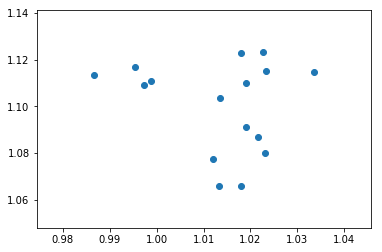

In [5]:
%matplotlib inline
ccd_names = ['00','01','02','10','11','12','20','21','22']
gains = [[d_cal[cdd][seg]['Fe55_gains'] for seg in d_cal[cdd].keys()] for cdd in d_cal.keys() ]/d_cal['11']['Segment03']['Fe55_gains'] 
intercal = [[d_cal[cdd][seg]['intercalib'] for seg in d_cal[cdd].keys()] for cdd in d_cal.keys()]
plt.scatter(gains[3], intercal[3])
d_cal.keys()

## Plot raw image (corrected for AVGBIAS for each amplifier)

In [4]:
im0 = raw_rack_image(d_cal, d_cal, intercal=False)
im0_filt = filtered_rack_image(im0)

In [5]:
np.shape(im0_filt)

(9, 4000, 4072)

/sps/lsst/users/ccombet/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


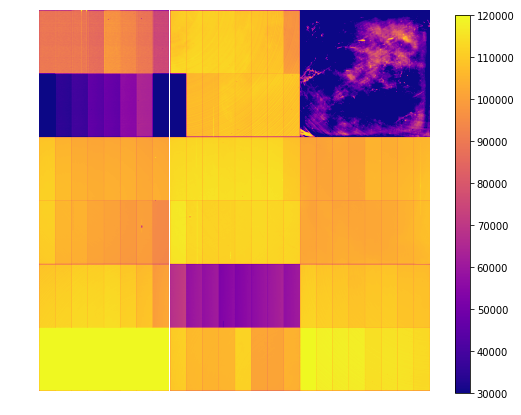

In [6]:
plot_rack_image(im0_filt, vmin=30000, vmax=120000)

In [7]:
im_cal1 = raw_rack_image(d_cal, d_cal, intercal='intercalib')
im_filt1 = filtered_rack_image(im_cal1)

In [8]:
im_cal2 = raw_rack_image(d_cal, d_cal, intercal='Fe55_gains')
im_filt2 = filtered_rack_image(im_cal2)

## Plot 'calibrated' image using calbiration coefficients computed above

* divided by avergae of central ccd to have relative calibration 

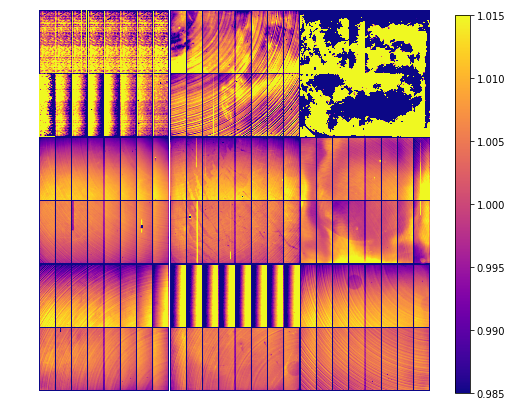

In [9]:
plot_rack_image(im_filt1/np.mean(im_filt1[4]), vmin=0.985, vmax=1.015)
#plot_rack_image(im_filt1)
#plot_rack_image(im_filt2)

In [44]:
global_ref = np.median(im_cal[4])
ccd_intercal = []
for i in np.arange(9):
    ccd_intercal.append(global_ref / np.median(im_cal[i]))
ccd_intercal    

[0.99158674492747056,
 1.000506090169013,
 0.99985843600155233,
 0.99999885200715877,
 1.0,
 1.0000297731411936,
 1.0001191020264022,
 1.0000839657777569,
 1.0001022312746308]

## CCOB centered on central ccd only

In [19]:
ledcurrent = '_0.01A'
exptime = '_0.1s'
led = 'red'

dirname = '/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/'
ccd_names=['00','01','02','10','11','12','20','21','22']
d={}
for ccd in ccd_names:
    filename_base = ccd + '_CCOB_' + led + ledcurrent + exptime
    l = glob.glob(dirname+filename_base+'*')
    myfile = l[0]
    dd = pyfits.open(myfile)
    print(ccd, myfile)
    d[ccd]=fill_seg_dict(dd)
#    channel_intercal(d[ccd])

for ccd in ccd_names:
    channel_intercal_with_Fe55_gains(d[ccd], d_gains[ccd])


00 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
01 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/01_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
02 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/02_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
10 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/10_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
11 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/11_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
12 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/12_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
20 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/20_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
21 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/21_CCOB_red_0.01A_0.1s_0000_20171117001651.fits
22 /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/22_CCOB_red_0.01A_0.1s_0000_20171117001651.fits


## Plot raw image (corrected for AVGBIAS for each amplifier)

* Can almost guess there is a beam there

In [8]:
im1 = raw_rack_image(d, d_cal, intercal=False)
im1_filt = filtered_rack_image(im1)


0 1.16832971266
1 1.20207960805
2 1.02932370371
3 1.13948730201
4 1.04899687352
5 1.04968978489
6 1.11941044611
7 1.02936696792
8 1.06852660561


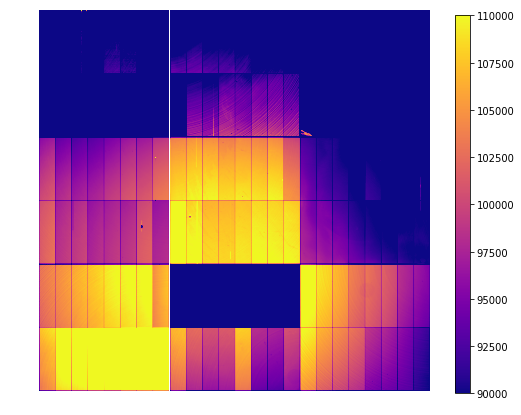

In [64]:
#plot_rack_image(im, vmin=90000, vmax=110000)
plot_rack_image(im1_filt, vmin=90000, vmax=110000)
#plot_rack_image(im, vmin=30000)
for i in np.arange(9):
    print(i, np.mean(im0_filt[i])/np.mean(im1_filt[i]))


## Correct all segments by calibration measured above

In [48]:
im_cal = raw_rack_image(d, d_cal, intercal='intercalib')
im_cal_filt = filtered_rack_image(im_cal)
#for i in np.arange(9):
#    im_cal[i] = im[i]*ccd_intercal[i]
#plot_rack_image(im_cal)

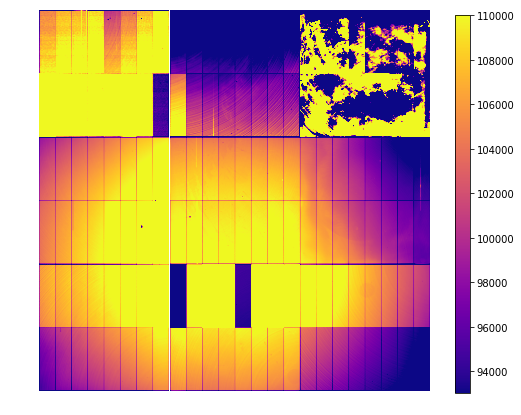

In [68]:
plot_rack_image(im_cal_filt, vmin=93000, vmax=110000)
#plot_rack_image(im_filt1, vmin=93000, vmax=110000)

In [4]:
im_cal2 = raw_rack_image(d, d, intercal='Fe55_gains')
tmp = filtered_rack_image(im_cal2)

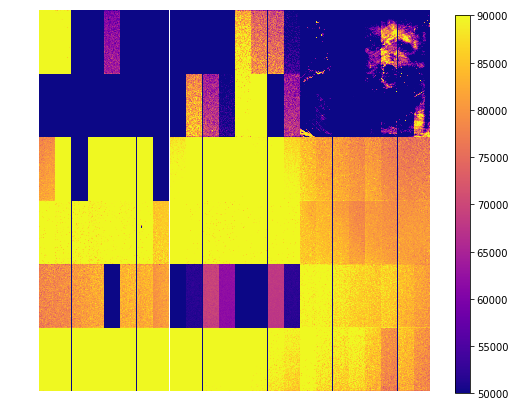

In [9]:
%matplotlib inline
plot_rack_image(im_cal2, vmin=50000, vmax=90000)

## JSR's polynomial calibration

In [22]:
import numpy as np
import scipy.ndimage as ndimage
from scipy import interpolate
from scipy import optimize

bx = 40
by = 5
edge = 20

# several functions used to get ccd data without border areas #

def safe(nx,ny):
    mx = np.append(np.arange(edge,nx/2-bx),np.arange(nx/2+bx,nx-edge))
    my = np.array([])
    vecy = np.arange(ny)
    chany = ny/8
    for i in np.arange(8):
        for val in vecy[int(chany*i+by):int(chany*(i+1)-by)]:
              my = np.append(my,int(val))
    my=my[edge-by:-(edge-by)].astype(int)
    return mx,my

lfit = 150

def getvxvy(ic, nx, ny):
     return getvx(ic,nx),getvy(ic,ny)

def getvx(ic, nx):
     if (ic>7):
        return np.arange(edge,nx/2-bx)
     else:
        return np.arange(nx/2+bx,nx-edge)

def getvy(ic, ny):
    chany = ny/8
    if ic>7:
          ic-=8
    zr = by
    zl = by
    if (ic==0):
          zl=edge
    if (ic==7):
        zr=edge
    vy = np.arange(chany*ic+zl,chany*(ic+1)-zr)
    return vy

def getsafevy(ic, ny):
    chany = ny/8
    if ic>7:
        ic-=8
    vy = np.append(np.arange(chany*ic-lfit,chany*ic-by), np.arange(chany*ic+by,chany*ic+lfit))
    return vy

def getbordervy(ic, ny):
    chany = ny/8
    if ic>7:
        ic-=8
    vy = np.arange(chany*ic-by, chany*ic+by)
    return vy

def poly(p, x):
    nx = x.size
    g = np.ones(nx)
    g[int(nx/2):]=p[3]
    return g*(p[0] * x*x + p[1] * x + p[2])

def errfuncy(p, x, y, err):
    return (y - poly(p,x)) / err

# calib ccd_data with channels gain
def calibgain(img, gain):
    nx, ny = img.shape
    chany = ny/8
    array = np.copy(img)
    for ic in np.arange(1,16):
        if ic<8:
            array[0:int(nx/2),int(ic*chany):int((ic+1)*chany)]=img[0:int(nx/2),int(ic*chany):int((ic+1)*chany)]/gain[ic]
        else:
            array[int(nx/2):nx,int((ic-8)*chany):int((ic-7)*chany)]=img[int(nx/2):nx,int((ic-8)*chany):int((ic-7)*chany)]/gain[ic]
    return array

# compute channels gain

def CalibGainPerChannel(img):
    array = ndimage.gaussian_filter(img, sigma=(9, 9), order=0)

    nx, ny = array.shape
    safe_x, safe_y = safe(nx,ny)
    
    chany = ny/8

    gain = np.ones(16)
    
    step = 100

    # compute gain of channel ic with respect to channel ic-1
    # exept for channel 0 and 8
    # gain[1:7] relative to channel 0
    # gain[9:15] relative to channel 8
    # NOTE that in this code channels are ordered
    # 0  1  2  3  4  5  6  7
    # 8  9 10 11 12 13 14 15
    # so my numbers do not correspond to the real channel numbers
    
    for ic in np.arange(1,16):
#        print(ic)
        if (ic==8):
            continue
        xs = 0
        xe = nx/2

        if ic>7:
            xs=nx/2
            xe=nx

        vx = safe_x[np.logical_and(safe_x>=xs,safe_x<xe)][::step]
                    
        vy = getsafevy(ic,ny)
        
        hg = np.array([])

        pinit = [1, 1, 1, 1.0]
        for ix in vx:
#            print(ix,vx)
            vay = array[int(ix),vy.astype(int)]
            vae = np.sqrt(vay)
            out = optimize.leastsq(errfuncy, pinit,
                                   args=(vy, vay, vae), full_output=1)
            pout = out[0]
            hg = np.append(hg,pout[3])
            cout = out[1]
        gain[ic] = np.median(hg)
        if ic<8:
            array[int(xs):int(xe),int(ic*chany):int((ic+1)*chany)]/=gain[ic]
        else:
            array[int(xs):int(xe),int((ic-8)*chany):int((ic-7)*chany)]/=gain[ic]

    # then compare 0-8, 1-9, ..., 7-15 and calib all channels with respect to channel 0
    vy=np.array([])
    for ic in np.arange(8):
        vy=np.append(vy,getsafevy(ic,ny))
    vy = vy[::step]
    vx = np.append(np.arange(nx/2-bx-lfit,nx/2-bx),np.arange(nx/2+bx,nx/2+bx+lfit))
    hg = np.array([])
    pinit = [1, 1, 1, 1.0]
    for iy in vy:
        vax = array[vx.astype(int),int(iy)]
        vae = np.sqrt(vax)
        out = optimize.leastsq(errfuncy, pinit,
                               args=(vx, vax, vae), full_output=1)
        pout = out[0]
        hg = np.append(hg,pout[3])
        cout = out[1]
    g = np.median(hg)
    #print 'up,down g = %5.3f +/- %5.3f' %(np.median(hg),np.std(hg))
    gain[8:]*=g
    return gain
    

def Smooth_and_Calib(img):
#    print('====== 1')
    chan_gain = CalibGainPerChannel(img)
    calib_img = calibgain(img,chan_gain)
    new_img = ndimage.gaussian_filter(calib_img, sigma=(9, 9), order=0)
#    print('====== 2')
    chan_gain = CalibGainPerChannel(new_img)
    calib_img = calibgain(new_img,chan_gain)
    new_img = ndimage.gaussian_filter(calib_img, sigma=(9, 9), order=0)
#    print('====== 3')
#    chan_gain = CalibGainPerChannel(new_img)
#    calib_img = calibgain(new_img,chan_gain)
#    new_img = ndimage.gaussian_filter(calib_img, sigma=(9, 9), order=0)
    return new_img, chan_gain


In [12]:
im = raw_rack_image(d_cal, d_cal, intercal=False)
im_new = []
gg = []
for i in np.arange(9):
    print(i)
    tmp, g = Smooth_and_Calib(im[i])
    im_new.append(tmp)
    gg.append(g)

0
1
2
3
4
5
6
7
8


In [46]:
tmp, g = Smooth_and_Calib(im_cal_filt[8])

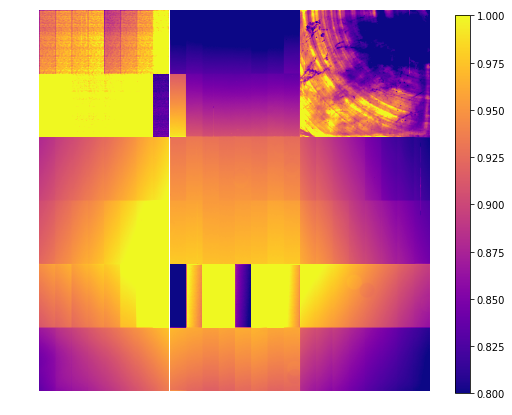

In [20]:
%matplotlib inline
#plt.imshow(np.flip(im1_filt[0]/im0_filt[0],axis=1), vmin=0.92, vmax=0.98, cmap='plasma', origin='lower')
plot_rack_image([im1_filt[i]/im0_filt[i] for i in np.arange(9)], vmin=0.8, vmax=1)
#plt.colorbar()


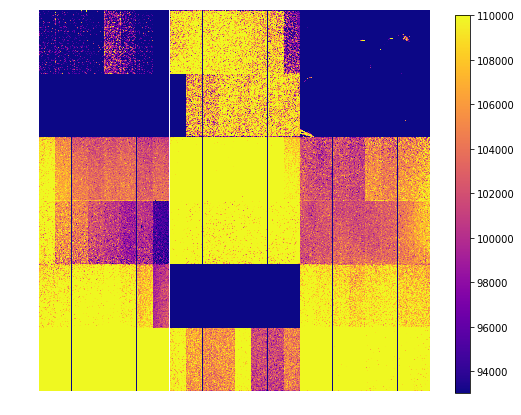

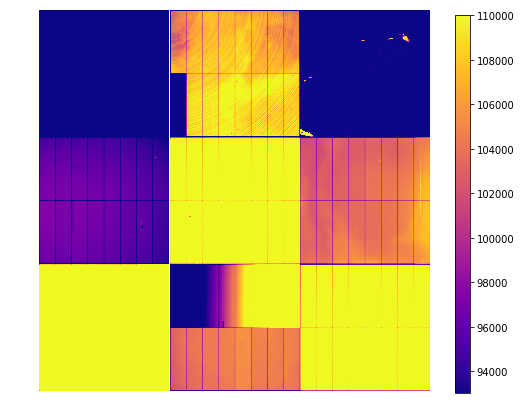

In [13]:
plot_rack_image(im, vmin=93000, vmax=110000)
plot_rack_image(im_new, vmin=93000, vmax=110000)

In [14]:
global_ref = np.median(im_new[4])
ccd_intercal = []
for i in np.arange(9):
    ccd_intercal.append(global_ref / np.median(im_new[i]))
ccd_intercal    

[3.1759578940623521,
 1.0517568556691583,
 13.830104308473894,
 1.092612060443007,
 1.0,
 1.1798744814393152,
 0.99999683206273882,
 1.0841506265933416,
 0.89105946965473748]

In [15]:
im_beam = raw_rack_image(d, d_cal, intercal=False)
im_new_beam = []
gg_beam = []
for i in np.arange(9):
    print(i)
    tmp, g = Smooth_and_Calib(im_beam[i])
    im_new_beam.append(tmp)
    gg_beam.append(g)

(9, 4000, 4072)


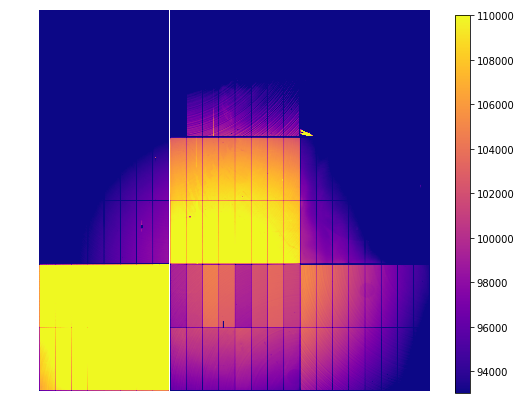

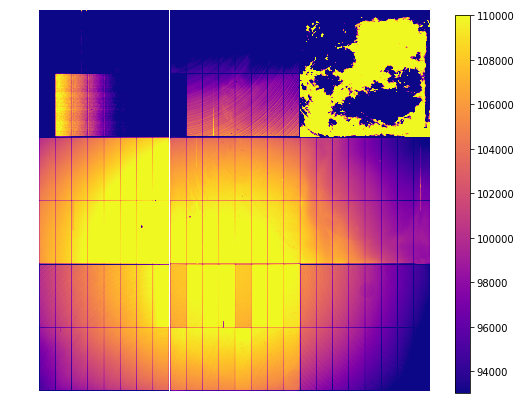

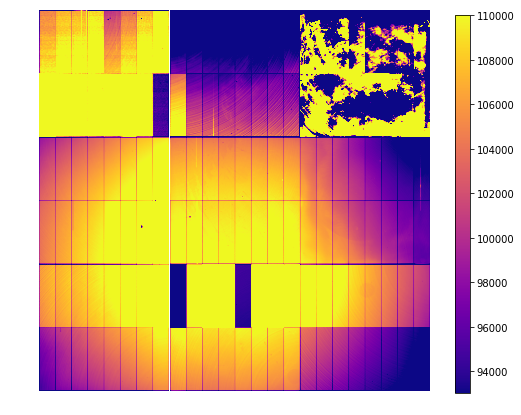

In [17]:
im_new_beam_cal=np.copy(im_new_beam)
print(np.shape(im_new_beam_cal))
for i in np.arange(9):
    im_new_beam_cal[i] = (im_new_beam[i]*ccd_intercal[i])

plot_rack_image(im_new_beam, vmin=93000, vmax=110000)
plot_rack_image(im_new_beam_cal, vmin=93000, vmax=110000)
plot_rack_image(filtered_rack_image(im_cal), vmin=93000, vmax=110000)



/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_red_0.012A_0.1s_0000_20171117181912.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_red_0.014A_0.1s_0000_20171117181058.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_red_0.01A_0.1s_0000_20171117001651.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/01_CCOB_red_0.012A_0.1s_0000_20171117181912.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/01_CCOB_red_0.014A_0.1s_0000_20171117181058.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/01_CCOB_red_0.01A_0.1s_0000_20171117001651.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/02_CCOB_red_0.012A_0.1s_0000_20171117181912.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/02_CCOB_red_0.014A_0.1s_0000_20171117181058.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/02_CCOB_red_0.01A_0.1s_0000_20171117001651.fits*
/sps/lsst/data/ccombet

In [8]:
ledcurrent = '_0.01A'
exptime = '_0.1s'
led = 'red'

dirname = '/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/'
ccd_names=['00','01','02','10','11','12','20','21','22']
d={}
ccd=ccd_names[0]    
filename_base = ccd + '_CCOB_' + led + ledcurrent + exptime
l = glob.glob(dirname+filename_base+'*')
myfile = l[0]
dd = pyfits.open(myfile)



In [4]:
ls /sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00*blue*

/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.001A_0.01s_0000_20171116232203.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.001A_0.1s_0000_20171116232324.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.001A_1.0s_0000_20171116232727.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.01A_0.01s_0000_20171116233258.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.01A_0.0555s_0000_20171116234646.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.01A_0.07s_0000_20171116235840.fits*
/sps/lsst/data/ccombet/CCOB/data_slac_1711/171116/testccob/00_CCOB_blue_0.01A_0.09s_0000_20171116234909.fits*


In [9]:
dd[0].header

SIMPLE  =                    T / Java FITS: Mon Nov 13 18:25:01 PST 2017        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2017-11-17T00:16:55.336' / Creation Date and Time of File            
DATE-OBS= '2017-11-17T00:16:51.373' / Date of the observation (image acquisition
MJD     =      58074.011751574 / Modified Julian Date that the file was written 
MJD-OBS = 58074.011705705896 / Modified Julian Date (5 decimal places) of image 
RUNNUM  = '0000    '           / The Run Number                                 
IMAGETAG= '1510877811373'      / Image tag (CCS/VST)                            
CONTNUM = '0000123b51d1'       / CCD Controller Serial Number                   
SEQFILE = 'TS8_ITL_ETU1_2s.seq' / Name of Sequencer File                        
CCD_MANU= 'ITL     '        